Copyright 2020 Andrew M. Olney and made available under [CC BY-SA](https://creativecommons.org/licenses/by-sa/4.0) for text and [Apache-2.0](http://www.apache.org/licenses/LICENSE-2.0) for code.


# Random forests

### What you will learn

Random forests are one of the most popular models in modern day data science and machine learning.
They combine decision trees with two new ideas:

- Random sampling of data 
- Random sampling of features

### When to use random forests

Random forests can be used in the same contexts as decision trees, namely when the relationship between the predictor variables and outcome is not additive.
Like decision trees, random forests can be used for classification or regression and are relatively fast.
While random forests generally have better performance than decision trees, the performance comes at a cost of fuzzier relationships between predictors.

## Random sampling of data

As we've seen, decision trees tend to overfit if we don't limit how large they can grow.
We can *regularize* the tree by applying a penalty to trees based on their size and fit.
Or we can simply restrict how large we'll allow trees to get, regardless of fit.

There is another way to deal with the overfitting problem that may surprise you - don't deal with it!
Instead of trying to make a single perfect tree, this approach is to make lots of imperfect trees, a **forest**.
It turns out that if we average the predictions of a lot of imperfect trees, we can get a prediction that is as good, or better, than a single perfect tree.
But there's a catch: this only works if the imperfect trees are *different* from each other.
Obviously, if they were all the same, then averaging them would give the same prediction as any one of them.

Random sampling of the data is one way we can ensure the trees in our forest are different from each other.
Every time we want to make a tree, we sample just part of our data and build a tree with that.
Because every sample is random, our trees will be different from each other.
This kind of sampling is called **bootstrapping**, which is just a funny way of saying that we are sampling *with replacement*.
An example of bootstrapping 10 cards from a deck of cards would be to shuffle the deck, draw 10 cards off the top, "use" them, and then put them back in the deck ("replace" them).

If we bootstrap a forest of trees, and then average (or combine) their predictions, this is called **bootstrap aggregating**, or **bagging** for short.
Don't worry if you find these names really strange, because you're not alone!
As an example of aggregation, suppose I have 100 trees in my forest, and I ask all of them to predict if someone has a disease or not (a binary classification task).
If 51 of them say `Positive` and 49 say `Negative`, then the majority are `Positive` and that is the prediction of the forest as a whole.
Another example would be a regression task, where each tree in the forest predicts the fuel economy (mpg) of a car based on its engine, weight, etc.
In that case, each regression tree in the forest would predict a numeric mpg, and these would be averaged to get the prediction of the forest as a whole.

## Bagging example

Bagging by itself is a data science technique, so we can try it out by itself before moving on to random forests.

If we were to do bagging from scratch, you might imagine we'd have a loop where each time we sampled some rows from a data frame, built a classifier, and then saved the classifier in a list.
Then when we wanted to classify something, we'd run it through each classifier in the list to get the predictions, and then we'd average those to get the final prediction.

Fortunately for us, `sklearn` takes care of all of those steps for us.

### Load data

Let's look at some breast cancer diagnostic [data](https://scikit-learn.org/stable/datasets/index.html#breast-cancer-dataset), which consists of the following variables as mean, standard error, and "worst" (mean of three largest variables) collected by digital imagery of a biopsy.

| Variable | Type | Description |
|:-------|:-------|:-------|
|radius | Ratio | mean of distances from center to points on the perimeter|
|texture | Ratio | standard deviation of gray-scale values|
|perimeter | Ratio | perimeter of cancer|
|area | Ratio | area of cancer|
|smoothness | Ratio | local variation in radius lengths|
|compactness | Ratio |  perimeter^2 / area - 1.0|
|concavity | Ratio |  severity of concave portions of the contour|
|concave points | Ratio |  number of concave portions of the contour|
|symmetry | Ratio | symmetry of cancer|
|fractal dimension | Ratio | "coastline approximation" - 1|
| class | Nominal (binary) | malignant (1) or benign (0)

<div style="text-align:center;font-size: smaller">
    <b>Source:</b> This dataset was taken from the UCI Machine Learning Repository library.
</div>
<br>

The goal is to predict the presence/absence of cancer.

We've worked with this dataset before, but this time instead of loading it from a `csv` file, we'll show how to load it from `sklearn`.

First, the imports for working with `sklearn` data and bagging:

- `import sklearn.datasets as datasets`
- `import sklearn.ensemble as ensemble`

In [11]:
import sklearn.datasets as datasets
import sklearn.ensemble as ensemble

#<xml xmlns="https://developers.google.com/blockly/xml"><variables><variable id="=l55S6$w5{IDU+4ID(5M">datasets</variable><variable id="YrOLY99XD^WJhuTK)IFx">ensemble</variable></variables><block type="importAs" id="PL5chXruGcet8N2(%vB@" x="51" y="74"><field name="libraryName">sklearn.datasets</field><field name="VAR" id="=l55S6$w5{IDU+4ID(5M">datasets</field><next><block type="importAs" id="aH_~S~W~@4D,8tXvn_s6"><field name="libraryName">sklearn.ensemble</field><field name="VAR" id="YrOLY99XD^WJhuTK)IFx">ensemble</field></block></next></block></xml>

We need to get the breast cancer data built into `sklearn` and put it in a variable:

- Set `cancer_sklearn` to with `datasets` do `load_breast_cancer`

In [12]:
cancer_sklearn = datasets.load_breast_cancer()

#<xml xmlns="https://developers.google.com/blockly/xml"><variables><variable id="etU=(k#nJyVsPHL@^Jv.">cancer_sklearn</variable><variable id="=l55S6$w5{IDU+4ID(5M">datasets</variable></variables><block type="variables_set" id="Jy]Veqr#Nz^tri-F}]~|" x="50" y="210"><field name="VAR" id="etU=(k#nJyVsPHL@^Jv.">cancer_sklearn</field><value name="VALUE"><block type="varDoMethod" id="FK0hhKS}if`R/ncgG?)]"><mutation items="1"></mutation><field name="VAR" id="=l55S6$w5{IDU+4ID(5M">datasets</field><field name="MEMBER">load_breast_cancer</field><data>datasets:load_breast_cancer</data></block></value></block></xml>

Now we can create the bagging classifier:

- Set `baggingClassifier` to with `ensemble` create `BaggingClassifier` using
    - freestyle `n_estimators=100`
    - freestyle `max_samples=.3`
    - freestyle `oob_score=True`
    - freestyle `random_state=1`
    
    
**Note:**
- `n_estimators` is the number of trees in our forest, here 100
- `max_samples` is the percentage of our data we'll sample for each tree, here 50%
- `oob_score` we'll talk about in a bit
- It's possible to tell BaggingClassifier to use any classfier, but it uses decision trees by default. That's what we did here.

In [13]:
baggingClassifier = ensemble.BaggingClassifier(n_estimators=100,max_samples=.3,oob_score=True,random_state=1)

#<xml xmlns="https://developers.google.com/blockly/xml"><variables><variable id=";_N-6qecLLc`fDM6%Iy#">baggingClassifier</variable><variable id="YrOLY99XD^WJhuTK)IFx">ensemble</variable></variables><block type="variables_set" id="Fyby#Z6`$J{8yxJ#gF-6" x="73" y="155"><field name="VAR" id=";_N-6qecLLc`fDM6%Iy#">baggingClassifier</field><value name="VALUE"><block type="varCreateObject" id="r3OQ@H/8b[IQZMW^g~*k"><mutation items="4"></mutation><field name="VAR" id="YrOLY99XD^WJhuTK)IFx">ensemble</field><field name="MEMBER">BaggingClassifier</field><data>ensemble:BaggingClassifier</data><value name="ADD0"><block type="dummyOutputCodeBlock" id="1Ngu=B.6@#0XXY3Ee}pw"><field name="CODE">n_estimators=100</field></block></value><value name="ADD1"><block type="dummyOutputCodeBlock" id="u*E7?6w]CWy9HrFCCq!Z"><field name="CODE">max_samples=.3</field></block></value><value name="ADD2"><block type="dummyOutputCodeBlock" id="A{D~w8=/nI[ik_-n`@2y"><field name="CODE">oob_score=True</field></block></value><value name="ADD3"><block type="dummyOutputCodeBlock" id="x%*#E(klF:]smI~uzw!/"><field name="CODE">random_state=1</field></block></value></block></value></block></xml>

Finally, `fit` and `score` the classifier:

- with `baggingClassifier` do `fit` using
    - from `cancer_sklearn` get `data`
    - from `cancer_sklearn` get `target`
- with `baggingClassifier` do `score` using
    - from `cancer_sklearn` get `data`
    - from `cancer_sklearn` get `target`

In [14]:
baggingClassifier.fit(cancer_sklearn.data,cancer_sklearn.target)

baggingClassifier.score(cancer_sklearn.data,cancer_sklearn.target)

#<xml xmlns="https://developers.google.com/blockly/xml"><variables><variable id=";_N-6qecLLc`fDM6%Iy#">baggingClassifier</variable><variable id="etU=(k#nJyVsPHL@^Jv.">cancer_sklearn</variable></variables><block type="varDoMethod" id=",p|wk`]$P`-Y!ceVzhp)" x="34" y="19"><mutation items="2"></mutation><field name="VAR" id=";_N-6qecLLc`fDM6%Iy#">baggingClassifier</field><field name="MEMBER">fit</field><data>baggingClassifier:fit</data><value name="ADD0"><block type="varGetProperty" id="R.;}jh_epNpo|{=vdhyi"><field name="VAR" id="etU=(k#nJyVsPHL@^Jv.">cancer_sklearn</field><field name="MEMBER">data</field><data>cancer_sklearn:data</data></block></value><value name="ADD1"><block type="varGetProperty" id="FN]3?ovaqNh2o9cKeqm,"><field name="VAR" id="etU=(k#nJyVsPHL@^Jv.">cancer_sklearn</field><field name="MEMBER">target</field><data>cancer_sklearn:target</data></block></value></block><block type="varDoMethod" id="v6LMxMyt~E%.kD#!w+V=" x="41" y="150"><mutation items="2"></mutation><field name="VAR" id=";_N-6qecLLc`fDM6%Iy#">baggingClassifier</field><field name="MEMBER">score</field><data>baggingClassifier:score</data><value name="ADD0"><block type="varGetProperty" id="M%CbZ0p%}^-bs++m-kNu"><field name="VAR" id="etU=(k#nJyVsPHL@^Jv.">cancer_sklearn</field><field name="MEMBER">data</field><data>cancer_sklearn:data</data></block></value><value name="ADD1"><block type="varGetProperty" id="=*KL*8pP=~p-m)U2A5Nj"><field name="VAR" id="etU=(k#nJyVsPHL@^Jv.">cancer_sklearn</field><field name="MEMBER">target</field><data>cancer_sklearn:target</data></block></value></block></xml>

0.9753954305799648

Hmm... that's a pretty tight fit to our data. 
How do we know that we are generalizing well, especially since we didn't split our data into training and testing sets?

Bagging introduces another idea here, which is **out of bag error (OOB)**. 
Remember that each tree is built with just some of the data, meaning the rest of the data could be used by testing.
So for each datapoint in the dataset, we calculate OOB performance by using only the trees in the forest that never saw that datapoint (a subforest if you will). 

To get the OOB score, do this:

- freestyle `baggingClassifier.oob_score_`

<!-- intellisense can sometimes hide this dynamic property -->
<!-- - `from baggingClassifier get oob_score_` -->

In [15]:
baggingClassifier.oob_score_

#<xml xmlns="https://developers.google.com/blockly/xml"><block type="dummyOutputCodeBlock" id="7FWtR3cc=SN_b_7nu9Zr" x="8" y="10"><field name="CODE">baggingClassifier.oob_score_</field></block></xml>

0.9543057996485061

That's pretty great - our OOB score is still very high and close to the overall accuracy on the dataset!

You'll only come across OOB in techniques that use bootstrapping, but it is closely related to another idea we'll talk about soon called **crossvalidation** that you can use with any model.

## Random sampling of features

Bagging is great, but can we make it better?
Remember the power of bagging is really that it makes each tree in the forest a little bit different from the others.
So anything else we can do to make trees a little different from each other could help too.

It turns out that even with bagging, each tree in the forest can still look kind of the same.
This is because each sample of data will still be *kind of* similar to the others: whatever properties are most common in the data will likely be the most common properties in any sample.
And since the decision trees are built the same way (e.g. using information gain as discussed previously), the same features will tend to be placed at the top nodes in all trees in the forest.

**Random forests** improve on bagging by randomly sampling the features to use at each node in each tree in the forest, in addition to using bagging.
So we can say that random forests are *doubly random* because they randomly sample data and randomly sample features when making each tree in the forest.
Random forests work the same way as bagging with regard to aggregation.

## Random forest example

Let's try it out:

- Set `randomForest` to with `ensemble` create `RandomForestClassifier` using
    - freestyle `n_estimators=100`
    - freestyle `max_samples=.3`
    - freestyle `oob_score=True`
    - freestyle `random_state=1`

In [16]:
randomForest = ensemble.RandomForestClassifier(n_estimators=100,max_samples=.3,oob_score=True,random_state=1)

#<xml xmlns="https://developers.google.com/blockly/xml"><variables><variable id="w_aKAuJ3s$kVqAIZ6-,=">randomForest</variable><variable id="YrOLY99XD^WJhuTK)IFx">ensemble</variable></variables><block type="variables_set" id="Fyby#Z6`$J{8yxJ#gF-6" x="34" y="125"><field name="VAR" id="w_aKAuJ3s$kVqAIZ6-,=">randomForest</field><value name="VALUE"><block type="varCreateObject" id="r3OQ@H/8b[IQZMW^g~*k"><mutation items="4"></mutation><field name="VAR" id="YrOLY99XD^WJhuTK)IFx">ensemble</field><field name="MEMBER">RandomForestClassifier</field><data>ensemble:RandomForestClassifier</data><value name="ADD0"><block type="dummyOutputCodeBlock" id="1Ngu=B.6@#0XXY3Ee}pw"><field name="CODE">n_estimators=100</field></block></value><value name="ADD1"><block type="dummyOutputCodeBlock" id="u*E7?6w]CWy9HrFCCq!Z"><field name="CODE">max_samples=.3</field></block></value><value name="ADD2"><block type="dummyOutputCodeBlock" id="A{D~w8=/nI[ik_-n`@2y"><field name="CODE">oob_score=True</field></block></value><value name="ADD3"><block type="dummyOutputCodeBlock" id="x%*#E(klF:]smI~uzw!/"><field name="CODE">random_state=1</field></block></value></block></value></block></xml>

`fit` and `score` the random forest:

- with `randomForest` do `fit` using
    - from `cancer_sklearn` get `data`
    - from `cancer_sklearn` get `target`
- with `randomForest` do `score` using
    - from `cancer_sklearn` get `data`
    - from `cancer_sklearn` get `target`

In [17]:
randomForest.fit(cancer_sklearn.data,cancer_sklearn.target)

randomForest.score(cancer_sklearn.data,cancer_sklearn.target)

#<xml xmlns="https://developers.google.com/blockly/xml"><variables><variable id="w_aKAuJ3s$kVqAIZ6-,=">randomForest</variable><variable id="etU=(k#nJyVsPHL@^Jv.">cancer_sklearn</variable></variables><block type="varDoMethod" id=",p|wk`]$P`-Y!ceVzhp)" x="34" y="19"><mutation items="2"></mutation><field name="VAR" id="w_aKAuJ3s$kVqAIZ6-,=">randomForest</field><field name="MEMBER">fit</field><data>randomForest:fit</data><value name="ADD0"><block type="varGetProperty" id="R.;}jh_epNpo|{=vdhyi"><field name="VAR" id="etU=(k#nJyVsPHL@^Jv.">cancer_sklearn</field><field name="MEMBER">data</field><data>cancer_sklearn:data</data></block></value><value name="ADD1"><block type="varGetProperty" id="FN]3?ovaqNh2o9cKeqm,"><field name="VAR" id="etU=(k#nJyVsPHL@^Jv.">cancer_sklearn</field><field name="MEMBER">target</field><data>cancer_sklearn:target</data></block></value></block><block type="varDoMethod" id="v6LMxMyt~E%.kD#!w+V=" x="41" y="150"><mutation items="2"></mutation><field name="VAR" id="w_aKAuJ3s$kVqAIZ6-,=">randomForest</field><field name="MEMBER">score</field><data>randomForest:score</data><value name="ADD0"><block type="varGetProperty" id="M%CbZ0p%}^-bs++m-kNu"><field name="VAR" id="etU=(k#nJyVsPHL@^Jv.">cancer_sklearn</field><field name="MEMBER">data</field><data>cancer_sklearn:data</data></block></value><value name="ADD1"><block type="varGetProperty" id="=*KL*8pP=~p-m)U2A5Nj"><field name="VAR" id="etU=(k#nJyVsPHL@^Jv.">cancer_sklearn</field><field name="MEMBER">target</field><data>cancer_sklearn:target</data></block></value></block></xml>

0.9824253075571178

Like the bagging model, the fit to the training data is pretty high. 
But also like the bagging model, we an look at OOB performance:

- freestyle `randomForest.oob_score_`

<!-- intellisense can sometimes hide this dynamic property -->
<!-- - `from randomForest get oob_score_` -->

In [18]:
randomForest.oob_score_

#<xml xmlns="https://developers.google.com/blockly/xml"><block type="dummyOutputCodeBlock" id="^x)gJaSt!)W%~#utRj+:" x="8" y="10"><field name="CODE">randomForest.oob_score_</field></block></xml>

0.961335676625659

Just by being a bit random with our features we can get a 1% OOB improvement.

## Visualizing ensemble models

Forests and bagging are examples of **ensemble** models, which are models made of other models.
We've seen how to interpret and visualize other models so far.
For example, linear and logistic regression models have coefficients that we can interpret as the strength or importance of predictors.
Decision trees likewise can be visualized as a tree graph.
However, when you have many, many different models in an ensemble, how can you visualize that?

### Feature importance

One way is with Gini importance.
Gini importance is a measure of how useful a predictor feature is in separating datapoints into classes.
In a decision tree, we can look at the node associated with a predictor in each tree, then look at the left and right branches under that node.
If the left and right branches are have a even mixture of classes in them, the Gini importance will be low, but if the left and right branches separate the classes well, the importance will be high.
We can then sum the Gini importance for a predictor across all the trees in the forest.
The Gini measure of feature importance is automatically calculated by `sklearn`, we just need to plot it.

We need `plotly.express` for plotting:

- `import plotly.express as px`


In [19]:
import plotly.express as px

#<xml xmlns="https://developers.google.com/blockly/xml"><variables><variable id="^?2M|ayhvs.c|vD]E$Iz">px</variable></variables><block type="importAs" id="O;j`Wb~P$i_O$hjHw|ry" x="16" y="10"><field name="libraryName">plotly.express</field><field name="VAR" id="^?2M|ayhvs.c|vD]E$Iz">px</field></block></xml>

And then we can create a bar chart of feature importances:

- with `px` do `bar` using
    - freestyle `x=` followed by from `cancer_sklearn` get `feature_names`
    - freestyle `y=` followed by from `randomForest` get `feature_importances_`

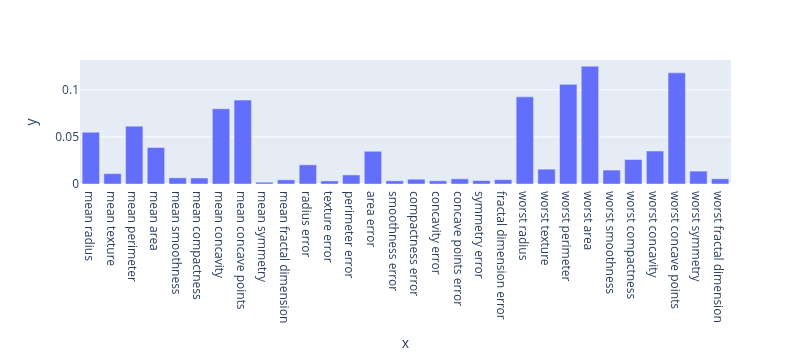

In [20]:
px.bar(x= (cancer_sklearn.feature_names),y= (randomForest.feature_importances_))

#<xml xmlns="https://developers.google.com/blockly/xml"><variables><variable id="^?2M|ayhvs.c|vD]E$Iz">px</variable><variable id="etU=(k#nJyVsPHL@^Jv.">cancer_sklearn</variable><variable id="w_aKAuJ3s$kVqAIZ6-,=">randomForest</variable></variables><block type="varDoMethod" id="*9~H!rAOPOD.29rUKmQ{" x="0" y="0"><mutation items="2"></mutation><field name="VAR" id="^?2M|ayhvs.c|vD]E$Iz">px</field><field name="MEMBER">bar</field><data>px:bar</data><value name="ADD0"><block type="valueOutputCodeBlock" id="wM!fm*a3[_(dX2gF,D)]"><field name="CODE">x=</field><value name="INPUT"><block type="varGetProperty" id="*t}AXL5lQ6wuZbSZVr_L"><field name="VAR" id="etU=(k#nJyVsPHL@^Jv.">cancer_sklearn</field><field name="MEMBER">feature_names</field><data>cancer_sklearn:feature_names</data></block></value></block></value><value name="ADD1"><block type="valueOutputCodeBlock" id="oMAa{yZp~wh|BF#Qq+ye"><field name="CODE">y=</field><value name="INPUT"><block type="varGetProperty" id="4tX%.+aJ!c((O-1Av[RY"><field name="VAR" id="w_aKAuJ3s$kVqAIZ6-,=">randomForest</field><field name="MEMBER">feature_importances_</field><data>randomForest:feature_importances_</data></block></value></block></value></block></xml>

We can see that the "worst" versions of the following measures (the average of the 3 largest values)

- Radius
- Perimeter
- Area
- Concave points

are very important for detecting breast cancer.
As these are mostly measures of size (except concave points), that makes sense.

Interestingly, the "mean" versions are similar but slightly different: concavity is now high, and area is now lower.

### Other visualizations

Other common options for visualization are visualizing each model in the ensemble (e.g. drawing the individual trees in the forest) or by looking at the *decision surface* of the ensemble.
The decision surface shows the regions in which the model classifies a datapoint into one class or another.
Consider this example from the `sklearn` documentation:

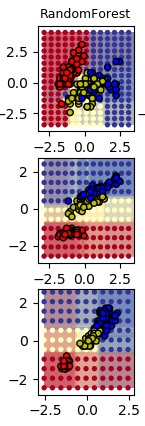

This plot shows three decision surfaces for the `iris` dataset, which has three classes of iris, in three subplots:

- The top plot shows a forest's predictions using sepal width and the sepal length 
- The middle plot shows a forest's  predictions using petal length and sepal length
- The bottom plot shows a forest's predictions using petal width and the petal length

This kind of plot can be very useful for understanding the overall prediction behavior of an ensemble, but since the plots are 2D, only two predictors can be shown at a time, making it a bit unwieldy for high-dimensional datasets.

## Check your knowledge

**Hover to see the correct answer.**

1.  What are the two new ideas that random forests combine with decision trees?
- Linear regression and logistic regression
- Boosting and bagging
- <span title="Correct Answer">Random sampling of data and random sampling of features</span>
- Cross-validation and regularization

2.  When are random forests generally preferred over single decision trees?
- When the relationship between predictor variables and outcome is additive.
- When faster performance is the only concern.
- When interpretability of individual tree relationships is paramount.
- <span title="Correct Answer">When generally better performance is desired, even at the cost of fuzzier predictor relationships.</span>

3.  What is **bootstrapping** in the context of creating a random forest?
- Sampling data without replacement.
- <span title="Correct Answer">Sampling data with replacement.</span>
- Penalizing trees based on their size.
- Restricting how large trees can grow.

4.  If 51 out of 100 trees in a random forest predict "Positive" for a binary classification task, what is the aggregated prediction of the forest?
- "Negative"
- Cannot be determined without more information
- <span title="Correct Answer">"Positive"</span>
- An average of the "Positive" and "Negative" outcomes

5.  What does `n_estimators=100` signify when creating a `BaggingClassifier` or `RandomForestClassifier`?
- The maximum depth of each tree.
- The number of features to sample for each tree.
- <span title="Correct Answer">The number of trees in the forest.</span>
- The minimum number of samples required to split an internal node.

6.  What is the purpose of the `oob_score=True` parameter in `BaggingClassifier` and `RandomForestClassifier`?
- To enable cross-validation for model evaluation.
- To automatically optimize hyperparameters.
- <span title="Correct Answer">To calculate the "out-of-bag" error, which uses data not seen by individual trees for testing.</span>
- To limit the maximum number of samples used for training.

7.  How do **random forests** improve upon plain bagging?
- By using more complex individual decision trees.
- By only sampling data and not features.
- <span title="Correct Answer">By randomly sampling features at each node in each tree, in addition to random data sampling.</span>
- By always growing perfect trees.

8.  What does **Gini importance** measure in the context of random forests?
- The overall accuracy of the model.
- The speed of the model's predictions.
- <span title="Correct Answer">How useful a predictor feature is in separating data points into classes.</span>
- The correlation between features.

9.  Based on the feature importance plot, which of the following "worst" measures are highly important for detecting breast cancer?
- Smoothness, Compactness, Concavity, Symmetry
- <span title="Correct Answer">Radius, Perimeter, Area, Concave points</span>
- Texture, Fractal dimension, Area, Smoothness
- Perimeter, Symmetry, Concave points, Fractal dimension

10. What is a limitation of visualizing the decision surface of an ensemble model?
- It only works for classification tasks.
- It cannot show the individual trees within the ensemble.
- <span title="Correct Answer">It can only show two predictors at a time, making it unwieldy for high-dimensional datasets.</span>
- It does not provide information about feature importance.

<!--  -->